# Stage 2 - Data Preprocessing

## Import Library and Load Dataset

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import seaborn as sns
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['font.family'] = 'sans-serif'
import seaborn as sns
plt.style.use('ggplot')
sns.set()

# Sklearn
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [ ]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [ ]:
! gdown 1Ug89rLFlYNGvZHKLORzQmMnZsdSXvgUn

Downloading...
From: https://drive.google.com/uc?id=1Ug89rLFlYNGvZHKLORzQmMnZsdSXvgUn
To: /content/aug_train.csv
100% 1.96M/1.96M [00:00<00:00, 101MB/s]


In [ ]:
path = 'aug_train.csv'
df = pd.read_csv(path)
df.sample(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
10273,27839,city_61,0.913,Male,Has relevent experience,no_enrollment,Graduate,STEM,11,50-99,Pvt Ltd,2,62,0.0
6722,491,city_104,0.924,Male,No relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,1,33,0.0
1817,32328,city_143,0.740,Female,No relevent experience,no_enrollment,Graduate,STEM,5,10000+,Pvt Ltd,2,91,0.0


# 1. Data Cleansing

## A. Handle Missing Value

In [ ]:
# Checking missing values
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

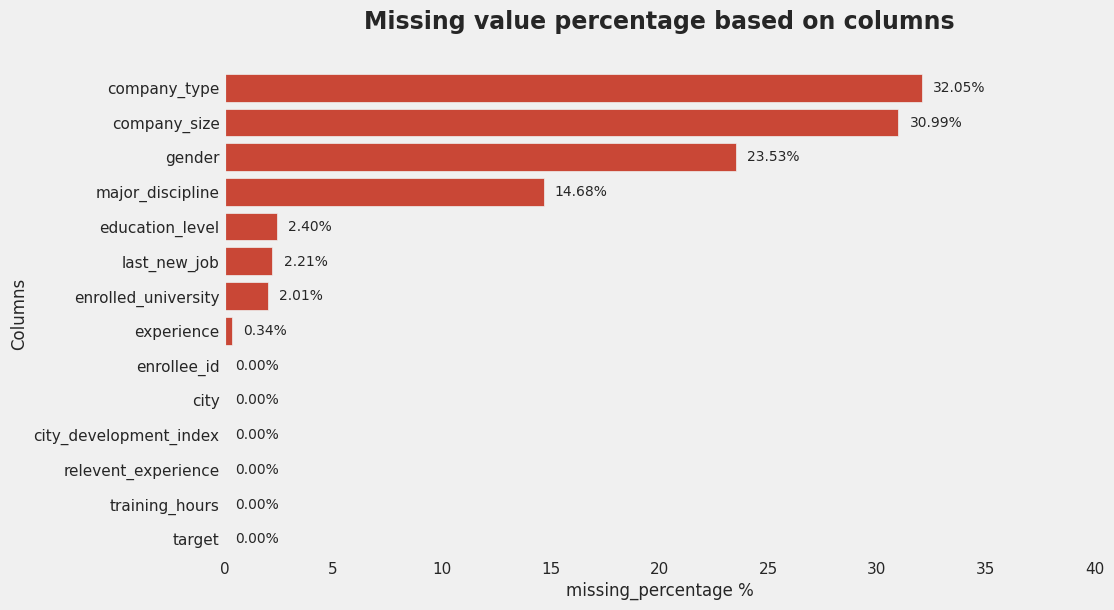

In [ ]:
# Plotting missing values each features percentage
missing = df.isnull().sum()*100 / len(df)

percentage_missing = pd.DataFrame({'column':df.columns,
                                   'missing_percentage %':missing.values})
percentage_missing['missing_percentage %'] = percentage_missing['missing_percentage %'].round(2)
percentage_missing = percentage_missing.sort_values('missing_percentage %', ascending=False)
percentage_missing = percentage_missing.reset_index()
percentage_missing = percentage_missing.drop('index', axis=1)

plt.figure(figsize=(10,6))
ax = sns.barplot(x='missing_percentage %', y='column', data=percentage_missing, color='#E1341E')
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width() + '%', xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(8, 0), textcoords='offset points' ,ha="left", va="center", fontsize=10)
plt.title('Missing value percentage based on columns', fontsize=17, fontweight='bold', pad=30)
plt.ylabel('Columns', fontsize=12)
plt.xlabel('missing_percentage %', fontsize=12)
plt.xlim(0,40)
plt.grid(False)
plt.show()

Handling Missing Values with Imputation Method

In [ ]:
#  make a copy of df
dfk = df.copy()

# Identify categorical columns
categorical_columns = dfk.select_dtypes(include=['object']).columns

# Create a SimpleImputer with 'most_frequent strategy
imp_mean = SimpleImputer(strategy='most_frequent')

# fit the imputer on the categorical columns in the dfk dataset
imp_mean.fit(dfk[categorical_columns])

# Impute the missing values in the categorical columns
dfk_imputed_categorical = pd.DataFrame(imp_mean.transform(dfk[categorical_columns]), columns= categorical_columns)

# Combine/concat the imputed categorical columns wiht the original integer columns
dfk = pd.concat([dfk_imputed_categorical, dfk.select_dtypes(exclude=['object'])], axis=1)

In [ ]:
dfk.isna().sum()

city                      0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
enrollee_id               0
city_development_index    0
training_hours            0
target                    0
dtype: int64

## B. Handle Duplicated Data

In [ ]:
#checking duplicated data for overall dataset
dfk.duplicated().sum()

0

In [ ]:
dfk['enrollee_id'].duplicated().sum()

0

'enrollee_id' merupakan feature yang menjadi penanda atau dapat disebut dengan primary key. dengan mengecek kemungkinan duplikasi yang ada pada kolom 'enrollee_id' dapat memastikan ada tidaknya data yang redundant.

## C. Feature Transformation<br>
Mengelompokkan ulang agar kategori menjadi lebih general dan mengurangi unique value.

In [ ]:
# there's 1 strange value in company_size feature
dfk.company_size.value_counts()

50-99        9021
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [ ]:
# Change problematic column
dfk['company_size'].replace('10/49', '10-49', inplace=True)

In [ ]:
dfk.loc[dfk['company_size']=='10-49'].head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,enrollee_id,city_development_index,training_hours,target
15,city_114,Male,Has relevent experience,no_enrollment,Graduate,STEM,16,10-49,Pvt Ltd,>4,6588,0.926,18,0.0
35,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,10,10-49,Early Stage Startup,2,4866,0.920,206,0.0
41,city_104,Male,Has relevent experience,no_enrollment,High School,STEM,4,10-49,Pvt Ltd,2,13854,0.924,36,0.0
49,city_83,Male,Has relevent experience,no_enrollment,Graduate,STEM,11,10-49,Pvt Ltd,1,25103,0.923,21,0.0
58,city_21,Male,Has relevent experience,Full time course,Graduate,STEM,2,10-49,Funded Startup,1,13478,0.624,32,1.0


In [ ]:
# city_development_index
conditions_city = [
    (dfk['city_development_index'] > 0.8),
    (dfk['city_development_index'] >= 0.6) & (dfk['city_development_index'] < 0.8),
    (dfk['city_development_index'] < 0.6)
]

choices_city = ['Highly Developed Cities', 'Moderately Developed Cities', 'Less Developed Cities']
dfk['city_category'] = np.select(conditions_city, choices_city, default='Unknown')

# last_new_job
conditions_last_job = [
    (dfk['last_new_job'] == '>4'),
    (dfk['last_new_job'] >= '2') & (dfk['last_new_job'] <= '4'),
    (dfk['last_new_job'].isin(['1', '<1']))
]

choices_last_job = ['High Tenure', 'Medium Tenure', 'Low Tenure']
dfk['last_new_job_category'] = np.select(conditions_last_job,
                                         choices_last_job,
                                         default='Never')

# experience
def categorize_experience(experience):
    experience = str(experience)
    if experience in ['10', '11', '12', '13', '14',
                      '15', '16', '17', '18', '19', '20', '>20']:
        return 'Senior Level'
    elif experience in ['4', '5', '6', '7', '8', '9']:
        return 'Intermediate Level'
    elif experience in ['<1', '1', '2', '3']:
        return 'Junior Level'
    return 'Unknown'

dfk['experience_category'] = dfk['experience'].apply(categorize_experience)

# company_size
conditions_company_size = [
    (dfk['company_size'].isin(['<10', '10-49', '50-99'])),
    (dfk['company_size'].isin(['100-500', '500-999'])),
    (dfk['company_size'].isin(['1000-4999', '5000-9999', '10000+']))
]

choices_company_size = ['Small', 'Medium', 'Large']
dfk['company_size_category'] = np.select(conditions_company_size, choices_company_size, default='Unknown')



In [ ]:
dfk\
.last_new_job_category\
.value_counts()

Low Tenure       8463
Medium Tenure    4953
High Tenure      3290
Never            2452
Name: last_new_job_category, dtype: int64

In [ ]:
dfk.columns

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job', 'enrollee_id', 'city_development_index',
       'training_hours', 'target', 'city_category', 'last_new_job_category',
       'experience_category', 'company_size_category'],
      dtype='object')

In [ ]:
new_cat_feature = ['city_category','last_new_job_category',
                   'experience_category', 'company_size_category']
for col in new_cat_feature:
    print(f'''Value Count column {col}:''')
    print(dfk[col].value_counts())
    print()

Value Count column city_category:
Highly Developed Cities        13192
Moderately Developed Cities     5241
Less Developed Cities            725
Name: city_category, dtype: int64

Value Count column last_new_job_category:
Low Tenure       8463
Medium Tenure    4953
High Tenure      3290
Never            2452
Name: last_new_job_category, dtype: int64

Value Count column experience_category:
Senior Level          8747
Intermediate Level    6859
Junior Level          3552
Name: experience_category, dtype: int64

Value Count column company_size_category:
Small     11800
Large      3910
Medium     3448
Name: company_size_category, dtype: int64



Visualization Category Distribution After Feature Transformation

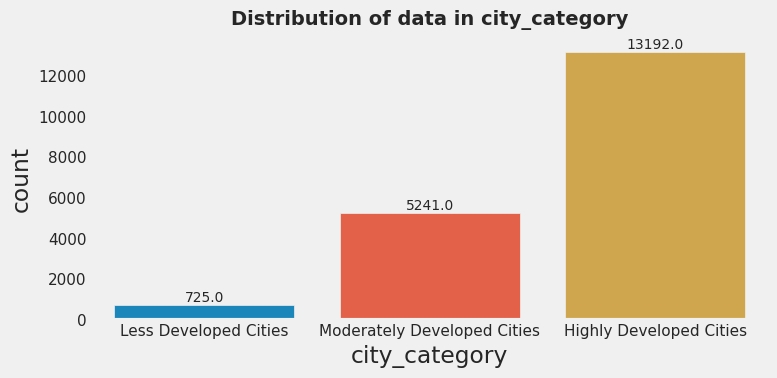

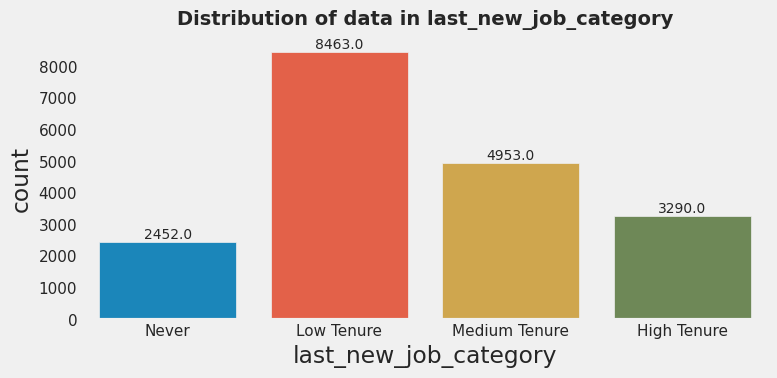

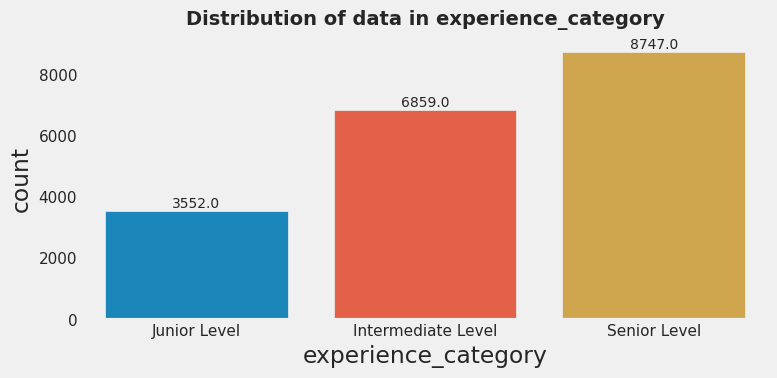

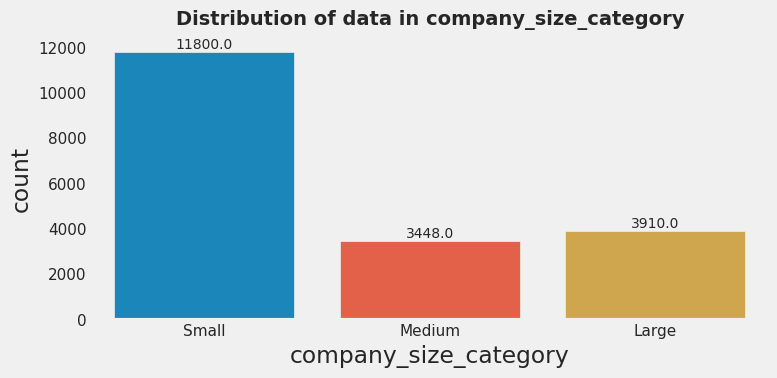

In [ ]:
# Define cats_feature for iterative plotting
cats_feature = ['city_category','last_new_job_category', 'experience_category','company_size_category']

# Define custom order for each category
category_order = {
    "city_category": ["Less Developed Cities", "Moderately Developed Cities", "Highly Developed Cities"],
    "last_new_job_category": ["Never", "Low Tenure", "Medium Tenure", "High Tenure" ],
    "experience_category": ["Junior Level", "Intermediate Level", "Senior Level"],
    "company_size_category": ["Small", "Medium", "Large"],
}

# Univariate analysis for categorical features
for feature in cats_feature:  # Make sure 'cats_feature' is defined
    # Create a subplot for each categorical feature
    plt.figure(figsize=(8, 4))

    # Countplot for categorical features with custom order
    sns.countplot(data=dfk, x=feature, order=category_order[feature])
    plt.title(f'Distribution of data in {feature}', size=14, fontweight='bold', pad=10)

    # Add frequency (count) labels to the bars
    ax = plt.gca()  # gets the current axes so that you can draw on it directly
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', size=10)

    plt.grid(False)
    plt.tight_layout()
    plt.show()


Ratio Visualization with the target

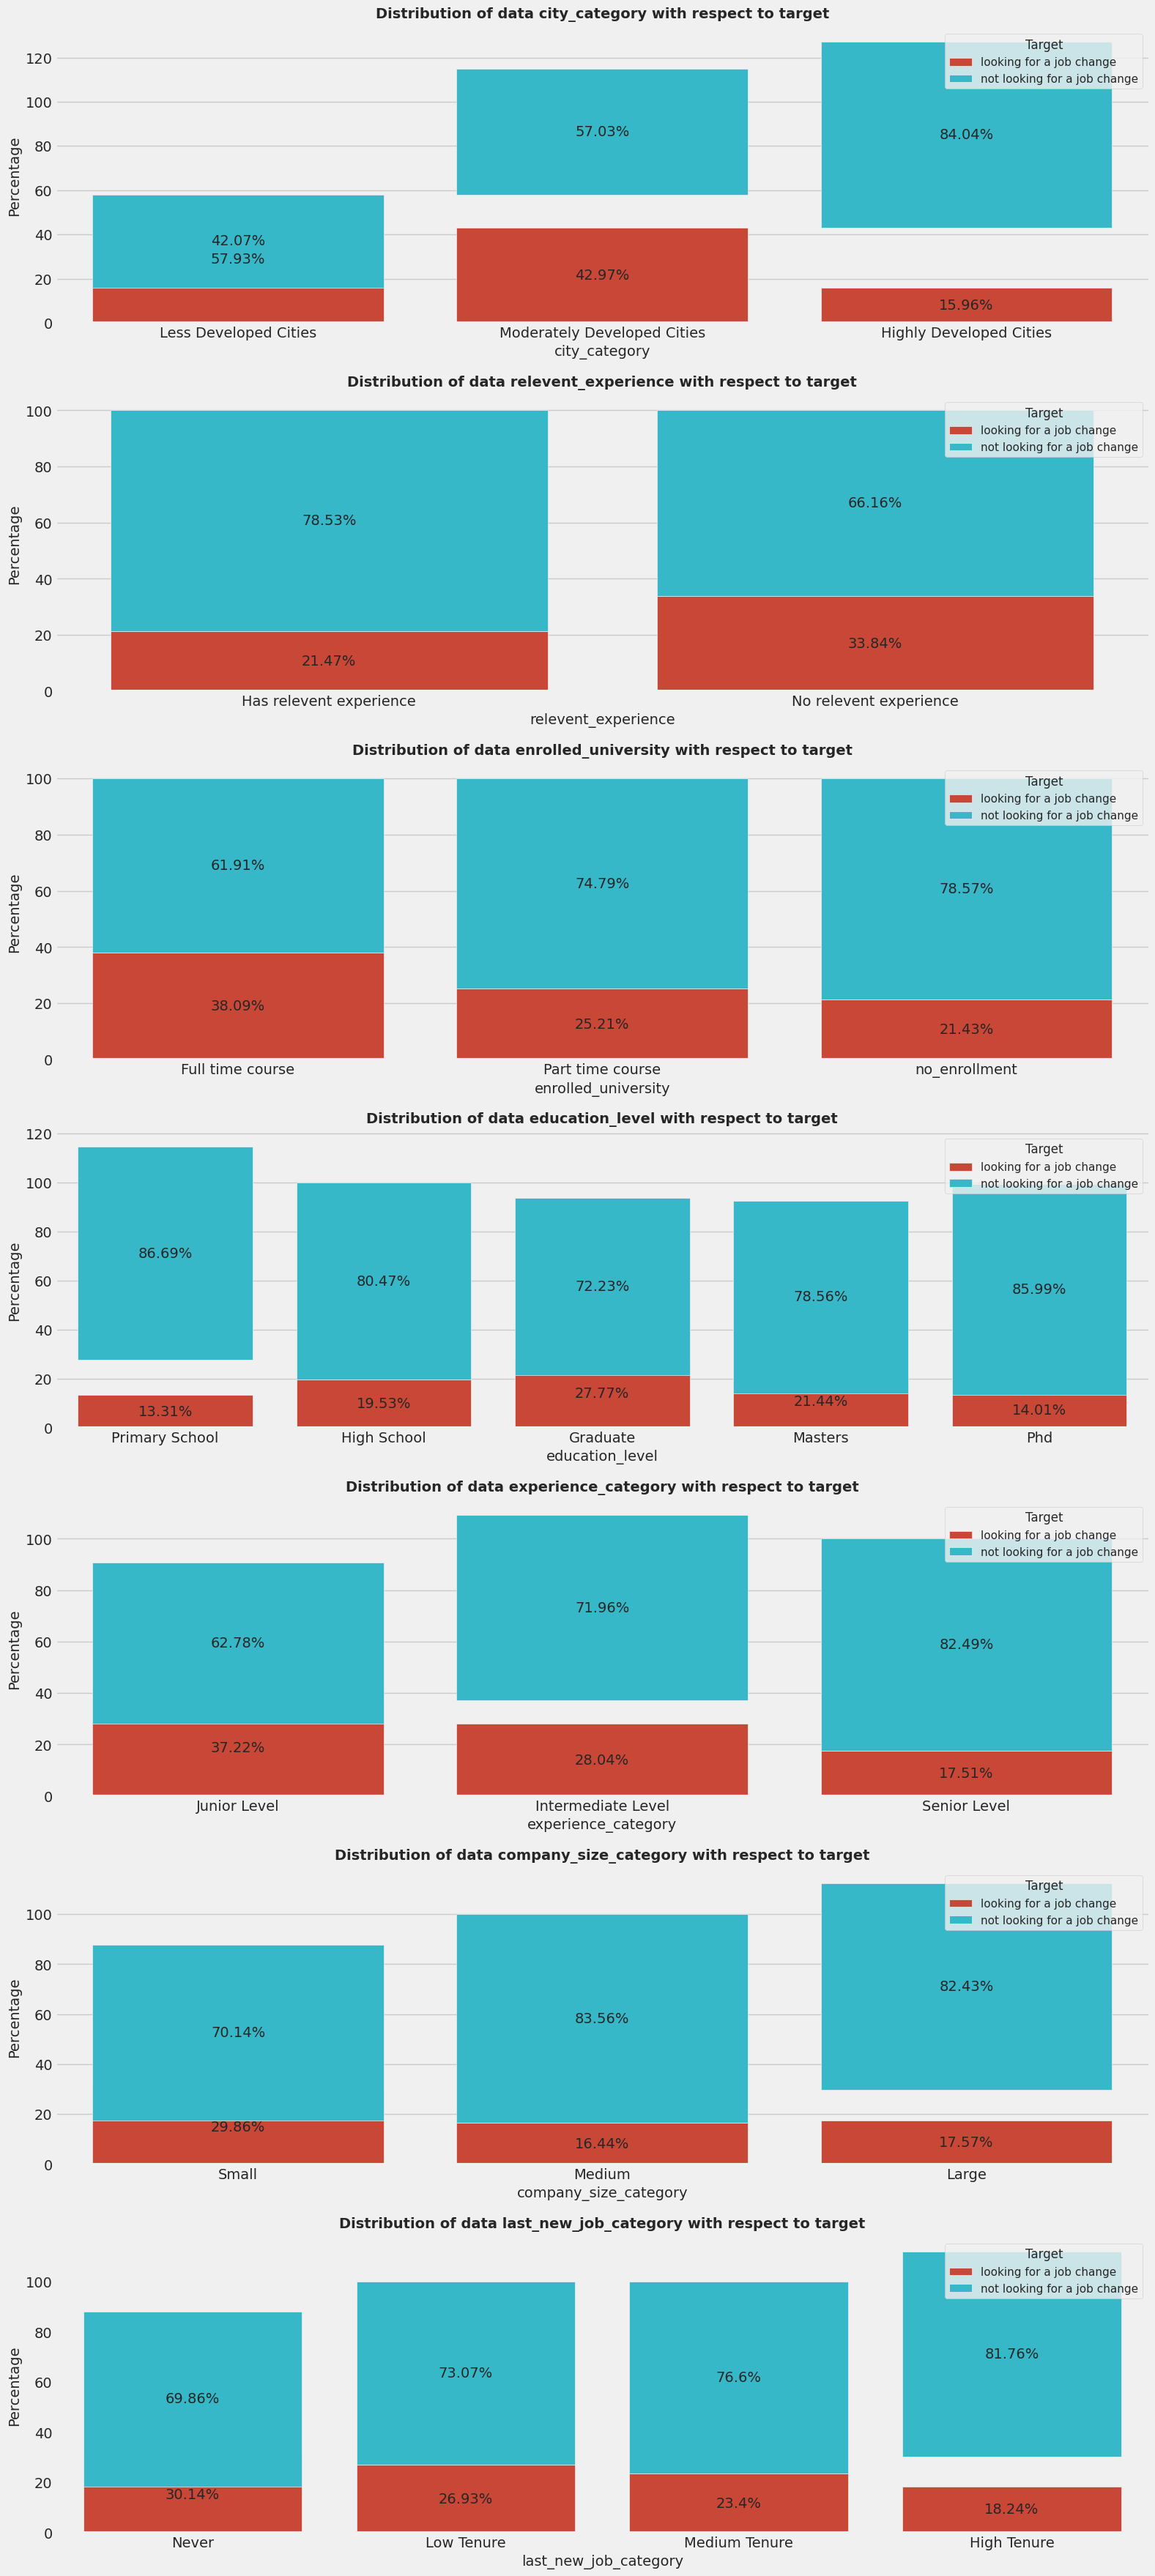

In [ ]:
# Separating columns based on data type
categorical_columns = ['city_category', 'relevent_experience', 'enrolled_university', 'education_level', 'experience_category', 'company_size_category', 'last_new_job_category']
target_column = 'target'

category_order = {
    "city_category": ["Less Developed Cities", "Moderately Developed Cities", "Highly Developed Cities"],
    "last_new_job_category": ["Never", "Low Tenure", "Medium Tenure", "High Tenure" ],
    "experience_category": ["Junior Level", "Intermediate Level", "Senior Level"],
    "company_size_category": ["Small", "Medium", "Large"],
    "education_level": ["Primary School","High School","Graduate","Masters","Phd"]}

plt.figure(figsize=(16, 50))
for i, column in enumerate(categorical_columns):
    plt.subplot(10, 1, i + 1)

    # Creating a crosstab between categorical column and target column
    crosstab = pd.crosstab(dfk[column], dfk[target_column])
    crosstab_percentage = crosstab.div(crosstab.sum(1), axis=0) * 100  # Calculating percentages

    # Creating a stacked bar chart
    ax = sns.barplot(
        x=crosstab_percentage.index,
        y=crosstab_percentage[1],
        order=category_order.get(column, None),  # Accessing category order based on column name
        color='#E1341E',
        label='looking for a job change'
    )
    ax = sns.barplot(
        x=crosstab_percentage.index,
        y=crosstab_percentage[0],
        order=category_order.get(column, None),  # Accessing category order based on column name
        color='#1ECBE1',
        label='not looking for a job change',
        bottom=crosstab_percentage[1]
    )
    for c in ax.containers:
        labels = [str(round(v.get_height(), 2)) + "%" if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c,
                     label_type='center',
                     labels=labels,
                     size=14)  # add a container object "c" as the first argument
    # Remove spines
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    # Add labels
    ax.tick_params(labelsize=14, labelrotation=0)
    ax.set_ylabel("Percentage", size=14)
    ax.set_xlabel(column, size=14)
    # Add legend
    ax.legend(fontsize=12,
              title="Target",
              title_fontsize=18,
              bbox_to_anchor=[0.55, 0.7])

    plt.xticks(rotation=0)
    plt.xlabel(column)
    plt.ylabel('Percentage')
    plt.title(f'Distribution of data {column} with respect to {target_column}', size=14, fontweight='bold', pad=10)
    plt.legend(title='Target', loc='upper right')

plt.grid(False)
plt.tight_layout()
plt.show()


Feature correlation with target after feature transformation

In [ ]:
categoric = dfk.select_dtypes('object')
# Create an empty DataFrame to store the chi-square results
chi_square_results = pd.DataFrame(columns=['Feature', 'Chi-Square', 'P-Value'])

# Calculate chi-square for each categorical feature
for feature in categoric :
    contingency_table = pd.crosstab(dfk[feature], dfk['target'])
    chi2, p, _, _ = chi2_contingency(contingency_table)


    # Create a temporary DataFrame and concatenate it to the results DataFrame
    temp_df = pd.DataFrame({'Feature' : [feature], 'Chi-Square' : [chi2], 'P-Value' : [p]})
    chi_square_results = pd.concat([chi_square_results, temp_df], ignore_index=True)


# Save the results to a CSV file
chi_square_results.to_csv('chi_square_results.csv', index=False)

# Print the chi square result Ordered by strongest Correlation
chi_squaresult = pd.read_csv('chi_square_results.csv')
chi_squaresult = chi_squaresult.sort_values(by=['Chi-Square'],ascending=False)

# adding correlation column in chi square result
chi_squaresult['Correlation'] = chi_squaresult['P-Value'].apply(lambda p: 'Significant' if p < 0.05 else 'Not Significant')
chi_squaresult.to_csv('chi_square_results.csv', index=False)
chi_square_resultsn = pd.read_csv('chi_square_results.csv')
chi_square_resultsn

,Feature,Chi-Square,P-Value,Correlation
0,city,2998.777229,0.000000e+00,Significant
1,city_category,1900.506111,0.000000e+00,Significant
2,experience,690.983270,1.066061e-132,Significant
3,company_size,592.964197,7.971606e-124,Significant
4,experience_category,578.894435,1.970927e-126,Significant
5,enrolled_university,440.458589,2.267945e-96,Significant
6,company_size_category,398.768270,2.561948e-87,Significant
7,relevent_experience,315.338577,1.500663e-70,Significant
8,education_level,160.454092,1.168254e-33,Significant
9,last_new_job,140.620659,1.320494e-28,Significant


# 2. Feature Engineering

## D. Feature Selection
Feature selection based on Chi-Square Correlation and P-Value

In [ ]:
dfk.columns

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job', 'enrollee_id', 'city_development_index',
       'training_hours', 'target', 'city_category', 'last_new_job_category',
       'experience_category', 'company_size_category'],
      dtype='object')

In [ ]:
# subsetting dfk to dfc
dfc = dfk[[
    # 'city', 'gender'
    'relevent_experience', 'enrolled_university','education_level',
    # 'major_discipline', 'experience', 'company_size',
      'company_type',
    # 'last_new_job', 'enrollee_id',
    #'city_development_index',  'training_hours',
    'target', 'city_category', 'last_new_job_category',
       'experience_category', 'company_size_category'
       ]].copy()

In [ ]:
dfc.head(3)

,relevent_experience,enrolled_university,education_level,company_type,target,city_category,last_new_job_category,experience_category,company_size_category
0,Has relevent experience,no_enrollment,Graduate,Pvt Ltd,1.0,Highly Developed Cities,Low Tenure,Senior Level,Small
1,No relevent experience,no_enrollment,Graduate,Pvt Ltd,0.0,Moderately Developed Cities,High Tenure,Senior Level,Small
2,No relevent experience,Full time course,Graduate,Pvt Ltd,0.0,Moderately Developed Cities,Never,Intermediate Level,Small


In [ ]:
categoric = dfc.drop(columns='target')
# Create an empty DataFrame to store the chi-square results
chi_square_results = pd.DataFrame(columns=['Feature', 'Chi-Square', 'P-Value'])

# Calculate chi-square for each categorical feature
for feature in categoric :
    contingency_table = pd.crosstab(dfc[feature], dfc['target'])
    chi2, p, _, _ = chi2_contingency(contingency_table)


    # Create a temporary DataFrame and concatenate it to the results DataFrame
    temp_df = pd.DataFrame({'Feature' : [feature], 'Chi-Square' : [chi2], 'P-Value' : [p]})
    chi_square_results = pd.concat([chi_square_results, temp_df], ignore_index=True)


# Save the results to a CSV file
chi_square_results.to_csv('chi_square_results.csv', index=False)

# Print the chi square result Ordered by strongest Correlation
chi_squaresult = pd.read_csv('chi_square_results.csv')
chi_squaresult = chi_squaresult.sort_values(by=['Chi-Square'],ascending=False)
chi_squaresult

# adding correlation column in chi square result
chi_squaresult['Correlation'] = chi_squaresult['P-Value'].apply(lambda p: 'Significant' if p < 0.05 else 'Not Significant')
chi_squaresult.to_csv('chi_square_results.csv', index=False)
chi_square_resultsn = pd.read_csv('chi_square_results.csv')
chi_square_resultsn

,Feature,Chi-Square,P-Value,Correlation
0,city_category,1900.506111,0.000000e+00,Significant
1,experience_category,578.894435,1.970927e-126,Significant
2,enrolled_university,440.458589,2.267945e-96,Significant
3,company_size_category,398.768270,2.561948e-87,Significant
4,relevent_experience,315.338577,1.500663e-70,Significant
5,education_level,160.454092,1.168254e-33,Significant
6,last_new_job_category,138.540836,7.799560e-30,Significant
7,company_type,91.187945,3.782007e-18,Significant


In [ ]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   relevent_experience    19158 non-null  object 
 1   enrolled_university    19158 non-null  object 
 2   education_level        19158 non-null  object 
 3   company_type           19158 non-null  object 
 4   target                 19158 non-null  float64
 5   city_category          19158 non-null  object 
 6   last_new_job_category  19158 non-null  object 
 7   experience_category    19158 non-null  object 
 8   company_size_category  19158 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


## E. Feature engineering - Feature Extraction
Tidak dilakukan karena semua feature berbentuk kategorik

## F. Feature engineering - Feature Encoding


In [ ]:
# Print all the feature value counts to Encode the feature Easier
for col in dfc:
    print(f'''Value Count column {col}:''')
    print(dfc[col].value_counts())
    print()

Value Count column relevent_experience:
Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64

Value Count column enrolled_university:
no_enrollment       14203
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64

Value Count column education_level:
Graduate          12058
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

Value Count column company_type:
Pvt Ltd                15957
Funded Startup          1001
Public Sector            955
Early Stage Startup      603
NGO                      521
Other                    121
Name: company_type, dtype: int64

Value Count column target:
0.0    14381
1.0     4777
Name: target, dtype: int64

Value Count column city_category:
Highly Developed Cities        13192
Moderately Developed Cities     5241
Less Developed Cities            725
Name: city_category, dtype: int64


### One Hot Encoding
Using One Hot Encoding to encode for all features that have been selected.

In [ ]:
# make a copy of df to make a new df where there's only One Hot Encoded Feature
dfohe = dfc.copy()

# One hot Encoding relevent feature
relevantx_encoded = pd.get_dummies(dfohe['relevent_experience'],prefix='candidate')
dfohe = pd.concat([dfohe, relevantx_encoded], axis=1)

# One hot Encoding enrolled university feature
enrolled_encoded = pd.get_dummies(dfohe['enrolled_university'], prefix='enrolled')
dfohe = pd.concat([dfohe, enrolled_encoded], axis=1)

#One hot Encoding education_level feature
edu_encoded = pd.get_dummies(dfohe['education_level'], prefix='edulevel')
dfohe = pd.concat([dfohe, edu_encoded], axis=1)

# One hot Encoding company_type
ctype_encoded = pd.get_dummies(dfohe['company_type'], prefix = 'comp_type')
dfohe = pd.concat([dfohe, ctype_encoded], axis=1)

#One hot Encoding city_category feature
city_encoded = pd.get_dummies(dfohe['city_category'], prefix = 'is')
dfohe = pd.concat([dfohe, city_encoded], axis=1)

#One hot Encoding last_new_job feature
njob_encoded = pd.get_dummies(dfohe['last_new_job_category'], prefix = 'has')
dfohe = pd.concat([dfohe, njob_encoded], axis=1)

#One hot Encoding experience_category feature
exp_encoded = pd.get_dummies(dfohe['experience_category'], prefix = 'is')
dfohe = pd.concat([dfohe, exp_encoded], axis=1)

#One hot Encoding company_size_category feature
size_encoded = pd.get_dummies(dfohe['company_size_category'], prefix = 'size')
dfohe = pd.concat([dfohe, size_encoded], axis=1)

# Drop all collumns except encoded columns
dfohe.drop(columns=['relevent_experience', 'enrolled_university', 'education_level',
                    'company_type', 'city_category', 'last_new_job_category',
                    'experience_category', 'company_size_category'], inplace=True)

In [ ]:
dfohe.sample(3)

,target,candidate_Has relevent experience,candidate_No relevent experience,enrolled_Full time course,enrolled_Part time course,enrolled_no_enrollment,edulevel_Graduate,edulevel_High School,edulevel_Masters,edulevel_Phd,edulevel_Primary School,comp_type_Early Stage Startup,comp_type_Funded Startup,comp_type_NGO,comp_type_Other,comp_type_Public Sector,comp_type_Pvt Ltd,is_Highly Developed Cities,is_Less Developed Cities,is_Moderately Developed Cities,has_High Tenure,has_Low Tenure,has_Medium Tenure,has_Never,is_Intermediate Level,is_Junior Level,is_Senior Level,size_Large,size_Medium,size_Small
2414,1.0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1
7479,1.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1
1379,0.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1


### One Hot & Label Encoding

Nominal features to Encode with One Hot Encoding : <br>

*   enrolled_university
*   company_type_category


In [ ]:
# One hot Encoding enrolled university feature
enrolled_encoded = pd.get_dummies(dfc['enrolled_university'], prefix='enrolled')
dfc = pd.concat([dfc, enrolled_encoded], axis=1)

# One hot Encoding company_type_category
ctype_encoded = pd.get_dummies(dfc['company_type'], prefix = 'comp_type')
dfc = pd.concat([dfc, ctype_encoded], axis=1)

# drop categorical column
dfc.drop(columns=['enrolled_university', 'company_type'], inplace=True)

Ordinal features to Label Encode : <br>

*   education_level
*   city_category
*   last_new_job
*   experience_category
*   company_size_category





In [ ]:
# Label Encoding features
# initialize label encoder
label_encoder = LabelEncoder()

# with Sklearn LabelEncoder

dfc['experience_category'] = label_encoder.fit_transform(dfc['experience_category'])
dfc['relevent_experience'] = label_encoder.fit_transform(dfc['relevent_experience'])

# Manual (mapping) label encoding

#encoded feature education_level
mapping_edu = {'Primary School':0,
               'High School':1,
               'Graduate':2,
               'Masters':3,
               'Phd':4
               }
dfc['education_level'] = dfc['education_level'].map(mapping_edu)

#encoded feature city_category
mapping_city_cat = {'Less Developed Cities':0,
                    'Moderately Developed Cities':1,
                    'Highly Developed Cities':2
                    }
dfc['city_category'] = dfc['city_category'].map(mapping_city_cat)

#encoded feature company_size_category
mapping_csize = {'Small':0,
                 'Large':1,
                 'Medium':2
                 }
dfc['company_size_category'] = dfc['company_size_category'].map(mapping_csize)

# encoded feature last_new_job
mapping_new_job = {'Never' : 0,
                   'Low Tenure' : 1,
                   'Medium Tenure' : 2,
                   'High Tenure' : 3}
dfc['last_new_job_category'] = dfc['last_new_job_category'].map(mapping_new_job)

for col in dfc.columns:
    value_counts = dfc[col].value_counts()
    print(f"Value Counts for {col}:\n{value_counts}\n")

Value Counts for relevent_experience:
0    13792
1     5366
Name: relevent_experience, dtype: int64

Value Counts for education_level:
2    12058
3     4361
1     2017
4      414
0      308
Name: education_level, dtype: int64

Value Counts for target:
0.0    14381
1.0     4777
Name: target, dtype: int64

Value Counts for city_category:
2    13192
1     5241
0      725
Name: city_category, dtype: int64

Value Counts for last_new_job_category:
1    8463
2    4953
3    3290
0    2452
Name: last_new_job_category, dtype: int64

Value Counts for experience_category:
2    8747
0    6859
1    3552
Name: experience_category, dtype: int64

Value Counts for company_size_category:
0    11800
1     3910
2     3448
Name: company_size_category, dtype: int64

Value Counts for enrolled_Full time course:
0    15401
1     3757
Name: enrolled_Full time course, dtype: int64

Value Counts for enrolled_Part time course:
0    17960
1     1198
Name: enrolled_Part time course, dtype: int64

Value Counts for enr

In [ ]:
dfc.sample(3)

,relevent_experience,education_level,target,city_category,last_new_job_category,experience_category,company_size_category,enrolled_Full time course,enrolled_Part time course,enrolled_no_enrollment,comp_type_Early Stage Startup,comp_type_Funded Startup,comp_type_NGO,comp_type_Other,comp_type_Public Sector,comp_type_Pvt Ltd
15293,0,2,1.0,1,1,0,2,0,0,1,0,0,0,0,1,0
14179,0,2,0.0,2,2,2,2,0,0,1,0,0,0,0,0,1
16155,1,2,1.0,1,1,0,0,0,1,0,0,0,0,0,0,1


## G. Handling Imbalanced Data

### SMOTE Over Sampling (Prefered)

#### SMOTE - One Hot Encoding Only
Use SMOTE method to balance the datasets with one hot encoding only

In [ ]:
# define x and y
x = dfohe.drop(columns='target')
y = dfohe['target']

#split x y train and x y test
x_trainohe, x_testohe, y_trainohe, y_testohe = train_test_split(x, y, test_size=0.3, random_state=17)

# Initialize SMOTE
smote = SMOTE(random_state=17)

# Doing oversampling to Data Train
x_overohe, y_overohe = smote.fit_resample(x_trainohe, y_trainohe)

In [ ]:
x_overohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20144 entries, 0 to 20143
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   candidate_Has relevent experience  20144 non-null  uint8
 1   candidate_No relevent experience   20144 non-null  uint8
 2   enrolled_Full time course          20144 non-null  uint8
 3   enrolled_Part time course          20144 non-null  uint8
 4   enrolled_no_enrollment             20144 non-null  uint8
 5   edulevel_Graduate                  20144 non-null  uint8
 6   edulevel_High School               20144 non-null  uint8
 7   edulevel_Masters                   20144 non-null  uint8
 8   edulevel_Phd                       20144 non-null  uint8
 9   edulevel_Primary School            20144 non-null  uint8
 10  comp_type_Early Stage Startup      20144 non-null  uint8
 11  comp_type_Funded Startup           20144 non-null  uint8
 12  comp_type_NGO     

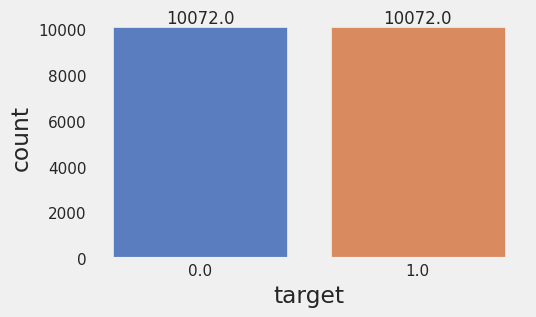

In [ ]:
# Set a custom color palette for the countplot
bright_palette = sns.color_palette("muted")

# Create the countplot with the custom color palette
plt.figure(figsize=(5, 3))
ax = sns.countplot(x=y_overohe, data=x_overohe, palette=bright_palette)
sns.despine()

# Add annotations to the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', size=12)

plt.grid(False)
plt.show()

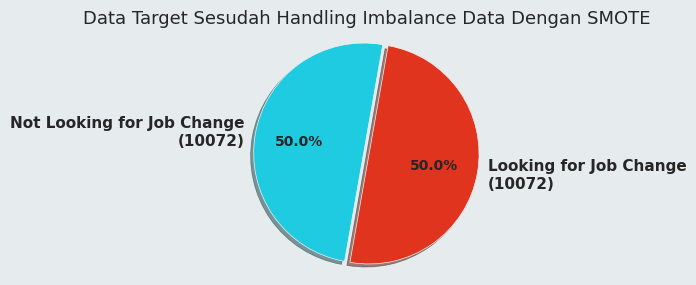

In [ ]:
target_counts = y_overohe.value_counts()

# Create a pie chart
fig, ax = plt.subplots(figsize=(6, 3))
fig.patch.set_facecolor('#e6ebed')

plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'bold'

wedges, texts, autotexts = ax.pie(target_counts,
                                   explode=(0.05, 0),
                                   labels=['Not Looking for Job Change', 'Looking for Job Change'],
                                   colors=['#1ECBE1', '#E1341E'],
                                   autopct='%1.1f%%',
                                   shadow=True,
                                   startangle=80)

plt.axis('equal')

# Display the total count of each category as text
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({target_counts.iloc[i]})')

plt.title('Data Target Sesudah Handling Imbalance Data Dengan SMOTE', fontsize=13)

plt.show()

#### SMOTE - Label and One Hot Encoding
Use SMOTE method to balance the datasets that use label and one hot encoding

In [ ]:
# define x and y
x = dfc.drop(columns='target')
y = dfc['target']

#split x y train and x y test
x_trainc, x_testc, y_trainc, y_testc = train_test_split(x, y, test_size=0.3, random_state=17)

# Initialize SMOTE
smote = SMOTE(random_state=17)

# Doing oversampling to Data Train
x_overc, y_overc = smote.fit_resample(x_trainc, y_trainc)

In [ ]:
x_overc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20144 entries, 0 to 20143
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   relevent_experience            20144 non-null  int64
 1   education_level                20144 non-null  int64
 2   city_category                  20144 non-null  int64
 3   last_new_job_category          20144 non-null  int64
 4   experience_category            20144 non-null  int64
 5   company_size_category          20144 non-null  int64
 6   enrolled_Full time course      20144 non-null  uint8
 7   enrolled_Part time course      20144 non-null  uint8
 8   enrolled_no_enrollment         20144 non-null  uint8
 9   comp_type_Early Stage Startup  20144 non-null  uint8
 10  comp_type_Funded Startup       20144 non-null  uint8
 11  comp_type_NGO                  20144 non-null  uint8
 12  comp_type_Other                20144 non-null  uint8
 13  comp_type_Public

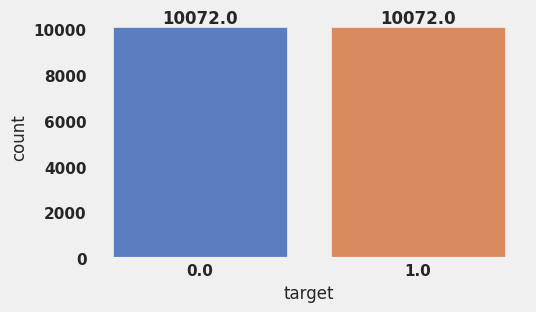

In [ ]:
# Set a custom color palette for the countplot
bright_palette = sns.color_palette("muted")

# Create the countplot with the custom color palette
plt.figure(figsize=(5, 3))
ax = sns.countplot(x=y_overc, data=x_overc, palette=bright_palette)
sns.despine()

# Add annotations to the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', size=12)

plt.grid(False)
plt.show()

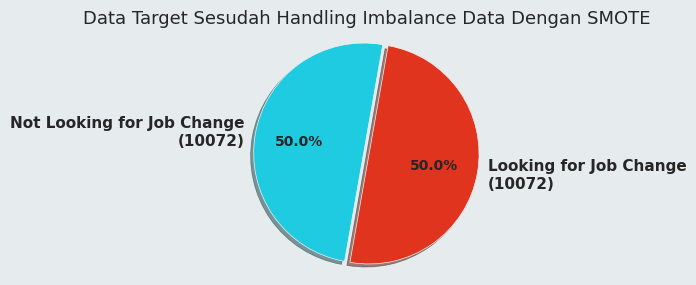

In [ ]:
target_counts = y_overc.value_counts()

# Create a pie chart
fig, ax = plt.subplots(figsize=(6, 3))
fig.patch.set_facecolor('#e6ebed')

plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'bold'

wedges, texts, autotexts = ax.pie(target_counts,
                                   explode=(0.05, 0),
                                   labels=['Not Looking for Job Change', 'Looking for Job Change'],
                                   colors=['#1ECBE1', '#E1341E'],
                                   autopct='%1.1f%%',
                                   shadow=True,
                                   startangle=80)

plt.axis('equal')

# Display the total count of each category as text
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({target_counts.iloc[i]})')

plt.title('Data Target Sesudah Handling Imbalance Data Dengan SMOTE', fontsize=13)

plt.show()

### Random Under Sampling (Not Prefered)

#### Random Under Sampling - One Hot Encoding Only
Use random under sampling method to balance the datasets with one hot encoding only

In [ ]:
# Initialize RandomUnderSampler to undersampler
undersampler = RandomUnderSampler(random_state=17)

# Undersampling Data Train OHE
x_underohe, y_underohe = undersampler.fit_resample(x_trainohe, y_trainohe)

In [ ]:
x_underohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6676 entries, 0 to 6675
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   candidate_Has relevent experience  6676 non-null   uint8
 1   candidate_No relevent experience   6676 non-null   uint8
 2   enrolled_Full time course          6676 non-null   uint8
 3   enrolled_Part time course          6676 non-null   uint8
 4   enrolled_no_enrollment             6676 non-null   uint8
 5   edulevel_Graduate                  6676 non-null   uint8
 6   edulevel_High School               6676 non-null   uint8
 7   edulevel_Masters                   6676 non-null   uint8
 8   edulevel_Phd                       6676 non-null   uint8
 9   edulevel_Primary School            6676 non-null   uint8
 10  comp_type_Early Stage Startup      6676 non-null   uint8
 11  comp_type_Funded Startup           6676 non-null   uint8
 12  comp_type_NGO       

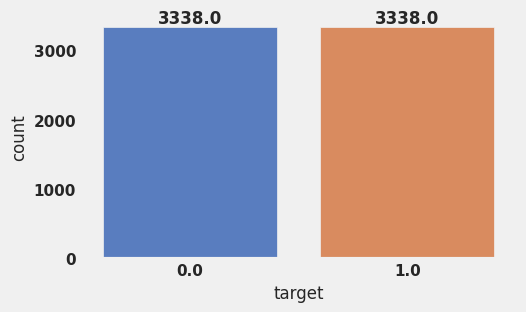

In [ ]:
# Set a custom color palette for the countplot
bright_palette = sns.color_palette("muted")

# Create the countplot with the custom color palette
plt.figure(figsize=(5, 3))
ax = sns.countplot(x=y_underohe, data=x_underohe, palette=bright_palette)
sns.despine()

# Add annotations to the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', size=12)

plt.grid(False)
plt.show()

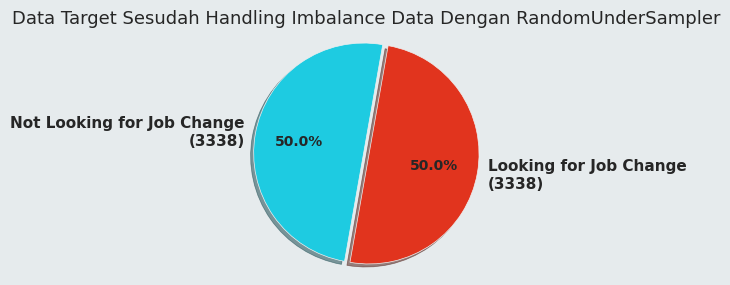

In [ ]:
target_counts = y_underohe.value_counts()

# Create a pie chart
fig, ax = plt.subplots(figsize=(6, 3))
fig.patch.set_facecolor('#e6ebed')

plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'bold'

wedges, texts, autotexts = ax.pie(target_counts,
                                   explode=(0.05, 0),
                                   labels=['Not Looking for Job Change', 'Looking for Job Change'],
                                   colors=['#1ECBE1', '#E1341E'],
                                   autopct='%1.1f%%',
                                   shadow=True,
                                   startangle=80)

plt.axis('equal')

# Display the total count of each category as text
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({target_counts.iloc[i]})')

plt.title('Data Target Sesudah Handling Imbalance Data Dengan RandomUnderSampler', fontsize=13)

plt.show()

#### Random Under Sampling - Label and One Hot Encoding
Use random under sampling method to balance the datasets that use label encoding and one hot encoding.

In [ ]:
undersampler = RandomUnderSampler(random_state=17)

x_underc, y_underc = undersampler.fit_resample(x_trainc, y_trainc)

In [ ]:
x_underc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6676 entries, 0 to 6675
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   relevent_experience            6676 non-null   int64
 1   education_level                6676 non-null   int64
 2   city_category                  6676 non-null   int64
 3   last_new_job_category          6676 non-null   int64
 4   experience_category            6676 non-null   int64
 5   company_size_category          6676 non-null   int64
 6   enrolled_Full time course      6676 non-null   uint8
 7   enrolled_Part time course      6676 non-null   uint8
 8   enrolled_no_enrollment         6676 non-null   uint8
 9   comp_type_Early Stage Startup  6676 non-null   uint8
 10  comp_type_Funded Startup       6676 non-null   uint8
 11  comp_type_NGO                  6676 non-null   uint8
 12  comp_type_Other                6676 non-null   uint8
 13  comp_type_Public S

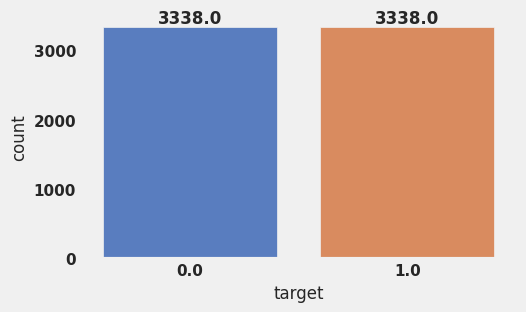

In [ ]:
# Set a custom color palette for the countplot
bright_palette = sns.color_palette("muted")

# Create the countplot with the custom color palette
plt.figure(figsize=(5, 3))
ax = sns.countplot(x=y_underc, data=x_underc, palette=bright_palette)
sns.despine()

# Add annotations to the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', size=12)

plt.grid(False)
plt.show()

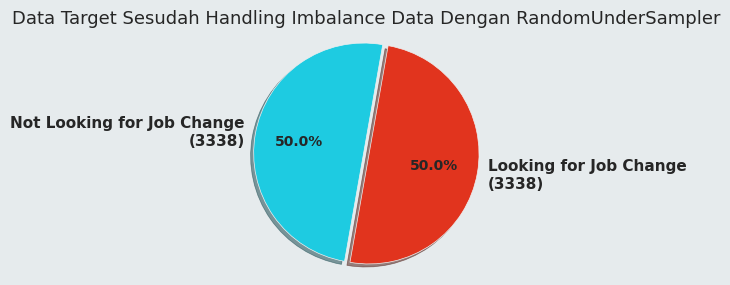

In [ ]:
target_counts = y_underc.value_counts()

# Create a pie chart
fig, ax = plt.subplots(figsize=(6, 3))
fig.patch.set_facecolor('#e6ebed')

plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'bold'

wedges, texts, autotexts = ax.pie(target_counts,
                                   explode=(0.05, 0),
                                   labels=['Not Looking for Job Change', 'Looking for Job Change'],
                                   colors=['#1ECBE1', '#E1341E'],
                                   autopct='%1.1f%%',
                                   shadow=True,
                                   startangle=80)

plt.axis('equal')

# Display the total count of each category as text
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({target_counts.iloc[i]})')

plt.title('Data Target Sesudah Handling Imbalance Data Dengan RandomUnderSampler', fontsize=13)

plt.show()